# Building Agents

시작하기 전에 [이 슬라이드](https://docs.google.com/presentation/d/13c0L1CQWAL7fuCXakOqjkvoodfynPJI4Hw_4H76okVU/edit?usp=sharing)를 참고하여 배경 지식을 확인하세요!

이메일 어시스턴트를 처음부터 구축해 보겠습니다. 
1) 랭그래프로 에이전트 아키텍처 설계
2) 랭스미스로 테스트
3) 휴먼 인 더 루프(Human-in-the-loop), 
4) 메모리 순으로 진행합니다. 

이 다이어그램은 각 구성 요소가 어떻게 결합되는지 보여줍니다:

![overview-img](assets/overview.png)

## Resources

- Notebook Reference: [agent.ipynb](https://github.com/langchain-ai/agents-from-scratch/blob/main/notebooks/agent.ipynb)
- For LangSmith Studio: [src/email_assistant](https://github.com/langchain-ai/agents-from-scratch/tree/main/src/email_assistant)
- Slides: [Building Ambient Agents with LangGraph - Building Agents & Evaluations.pdf](https://files.cdn.thinkific.com/file_uploads/967498/attachments/5f6/a6b/958/Building_Ambient_Agents_with_LangGraph_-_Building_Agents___Evaluations.pdf)



## 환경 설정

In [2]:
from dotenv import load_dotenv


load_dotenv("../../.env", override=True)

True

## 도구 정의

이메일 어시스턴트가 사용할 간단한 도구들을 `@tool` 데코레이터로 정의합니다.

In [3]:
from datetime import datetime

from langchain_core.tools import tool
from pydantic import BaseModel


@tool
def write_email(to: str, subject: str, content: str) -> str:
    """이메일을 작성하여 보냅니다."""
    # 임시 응답 - 실제 앱에서는 이메일을 발송합니다
    return f"{to}에게 발송된 이메일, 제목: '{subject}', 내용: {content}"


@tool
def schedule_meeting(
    attendees: list[str],
    subject: str,
    duration_minutes: int,
    preferred_day: datetime,
    start_time: int,
) -> str:
    """캘린더에 회의를 예약합니다."""
    # 임시 응답 - 실제 앱에서는 캘린더와 일정을 확인합니다
    date_str = preferred_day.strftime("%A, %B %d, %Y")
    return f"'{subject}' 회의가 {date_str} {start_time}에 {duration_minutes}분 동안 {len(attendees)}명의 참석자와 함께 예정되어 있습니다"


@tool
def check_calendar_availability(day: str) -> str:
    """특정 날짜의 캘린더 가능 시간을 확인합니다."""
    # 임시 응답 - 실제 앱에서는 실제 캘린더를 확인합니다
    return f"{day}의 가능한 시간: 오전 9:00, 오후 2:00, 오후 4:00"


@tool
class Done(BaseModel):
    """이메일이 발송되었습니다."""

    done: bool

## 이메일 어시스턴트 구축하기

라우터와 에이전트를 결합하여 이메일 어시스턴트를 구축합니다.

![agent_workflow_img](./assets/email_workflow.png)

### 라우터(Router)

라우팅 단계는 분류 결정을 처리합니다.

분류 라우터는 분류 결정에만 집중하고, 에이전트는 응답에만 집중합니다.

#### 상태(State)

에이전트를 구축할 때는 시간에 따라 추적하고자 하는 정보를 고려하는 것이 중요합니다. 이번 프로젝트에서는 LangGraph의 사전 구축된 [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)를 사용합니다. `MessagesState`를 확장하여 `email_input`와 `classification_decision` 키를 추가하는 사용자 정의 `State` 객체를 정의합니다.

In [4]:
from typing import Literal

from langgraph.graph import MessagesState


class State(MessagesState):
    email_input: dict
    classification_decision: Literal["ignore", "respond", "notify"]

#### 분류 노드

분류 라우팅 로직을 포함하는 함수를 정의합니다. 
이를 위해 [`structured_outputs`](https://python.langchain.com/docs/concepts/structured_outputs/)을 사용합니다. 

`Pydantic`은 타입 힌트와 유효성 검사를 제공하기 때문에 구조화된 출력 스키마를 정의하는 데 유용합니다. 

Pydantic 모델의 설명(description)은 JSON 스키마의 일부로 LLM에 전달되어 출력 변환에 대한 정보를 제공합니다.

In [5]:
from email_assistant.prompts import (
    default_background,
    default_triage_instructions,
    triage_system_prompt,
    triage_user_prompt,
)
from email_assistant.utils import format_email_markdown, parse_email
from IPython.display import Markdown, display  # noqa: A004


print("")
print("=" * 20 + " triage_system_prompt " + "=" * 20)
display(Markdown(triage_system_prompt))

print("")
print("=" * 20 + " triage_user_prompt " + "=" * 20)
display(Markdown(triage_user_prompt))

print("")
print("=" * 20 + " default_background " + "=" * 20)
display(Markdown(default_background))

print("")
print("=" * 20 + " default_triage_instructions " + "=" * 20)
display(Markdown(default_triage_instructions))


==================== triage_system_prompt ====================



< 역할 >
당신의 역할은 아래 지침과 배경 정보를 바탕으로 수신된 이메일을 분류하는 것입니다.
</ 역할 >

< 배경 >
{background}
</ 배경 >

< 지침 >
각 이메일을 다음 세 가지 카테고리 중 하나로 분류하세요:
1. IGNORE - 응답하거나 추적할 가치가 없는 이메일
2. NOTIFY - 알림이 필요하지만 응답이 필요하지 않은 중요한 정보
3. RESPOND - 직접적인 응답이 필요한 이메일
아래 이메일을 이 카테고리 중 하나로 분류하세요.
</ 지침 >

< 규칙 >
{triage_instructions}
</ 규칙 >



==================== triage_user_prompt ====================



아래 이메일 스레드를 어떻게 처리할지 결정해주세요:

발신: {author}
수신: {to}
제목: {subject}
{email_thread}


==================== default_background ====================



저는 Lance이고, LangChain의 소프트웨어 엔지니어입니다.



==================== default_triage_instructions ====================



응답할 가치가 없는 이메일:
- 마케팅 뉴스레터 및 홍보 이메일
- 스팸 또는 의심스러운 이메일
- 직접적인 질문이 없는 참조용(CC) 스레드

또한 알아야 하지만 이메일 응답이 필요하지 않은 것들도 있습니다. 이런 경우 알림(`notify` 응답)을 사용해야 합니다. 예시:
- 팀원의 병가 또는 휴가
- 빌드 시스템 알림 또는 배포
- 조치가 필요 없는 프로젝트 상태 업데이트
- 중요한 회사 공지사항
- 현재 프로젝트와 관련된 정보가 포함된 참조용 이메일
- 인사부 마감일 알림
- 구독 상태 / 갱신 알림
- GitHub 알림

응답할 가치가 있는 이메일:
- 전문 지식이 필요한 팀원의 직접적인 질문
- 확인이 필요한 회의 요청
- 팀 프로젝트와 관련된 심각한 버그 보고
- 확인이 필요한 관리자의 요청
- 프로젝트 상태나 기능에 대한 클라이언트 문의
- 문서, 코드 또는 API에 대한 기술적 질문(특히 누락된 엔드포인트나 기능에 대한 질문)
- 가족과 관련된 개인 알림(아내 / 딸)
- 자기 관리와 관련된 개인 알림(병원 예약 등)


In [6]:
from typing import Annotated, Literal

from pydantic import BaseModel, Field

from langchain.chat_models import init_chat_model


class RouterSchema(BaseModel):
    """읽지 않은 이메일을 분석하고 내용에 따라 처리 경로를 지정하십시오."""

    reasoning: Annotated[str, Field(description="분류의 단계별 추론 과정.")]

    classification: Annotated[
        Literal["ignore", "respond", "notify"],
        Field(
            description="이메일 분류: 관련 없는 이메일은 'ignore', "
            "답변이 필요 없는 중요한 정보는 'respond', "
            "답변이 필요한 이메일은 'notify'"
        ),
    ]


llm = init_chat_model("openai:gpt-4.1-mini", temperature=0)
llm_router = llm.with_structured_output(RouterSchema)

In [7]:
response = llm_router.invoke("""안녕하세요,
저희 새로운 AI 기반 분석 플랫폼 출시를 알려드립니다! 저희 가치 있는 고객님을 위해 처음 3개월간 50% 할인을 제공합니다.
이 제한된 기간 동안만 이메일 구독자에게만 제공되는 특별 혜택입니다. 아래 버튼을 클릭하여 할인을 받으세요:
[지금 50% 할인 받기]
이 오퍼는 48시간 내에 만료됩니다.
감사합니다,
마케팅팀""")

print("classification:", response.classification)
print("reasoning:", response.reasoning)

classification: notify
reasoning: 이 이메일은 새로운 AI 기반 분석 플랫폼 출시와 관련된 마케팅 프로모션을 알리는 내용으로, 할인 혜택을 제공하며 수신자에게 행동을 유도하고 있습니다. 이는 명백한 광고 및 프로모션 이메일로 분류됩니다.


In [8]:
from langgraph.types import Command


def triage_router(state: State) -> Command[Literal["response_agent", "__end__"]]:
    """이메일 내용을 분석하여 응답, 알림 또는 무시 여부를 결정합니다."""

    author, to, subject, email_thread = parse_email(state["email_input"])
    system_prompt = triage_system_prompt.format(
        background=default_background, triage_instructions=default_triage_instructions
    )

    user_prompt = triage_user_prompt.format(
        author=author, to=to, subject=subject, email_thread=email_thread
    )

    result = llm_router.invoke(
        [
            ("system", system_prompt),
            ("user", user_prompt),
        ]
    )
    assert isinstance(result, RouterSchema)

    if result.classification == "respond":
        print("📧 분류: 응답 필요 - 이 이메일은 답변이 필요합니다")
        return Command(
            goto="response_agent",
            update={
                "messages": [
                    (
                        "user",
                        f"이메일에 답장하세요: \n\n{format_email_markdown(subject, author, to, email_thread)}",
                    )
                ],
                "classification_decision": result.classification,
            },
        )

    if result.classification == "ignore":
        print("🚫 분류: 무시 - 이 이메일은 안전하게 무시해도 됩니다")
        return Command(
            goto="__end__",
            update={"classification_decision": result.classification},
        )

    if result.classification == "notify":
        print("🔔 분류: 알림 - 이 이메일에는 중요한 정보가 포함되어 있습니다")
        return Command(
            goto="__end__",
            update={"classification_decision": result.classification},
        )

    raise ValueError(f"Invalid classification: {result.classification}")


In [9]:
email_input = {
    "email_id": "1234",
    "author": "marketing@company.com",
    "to": "user@example.com",
    "subject": "신제품 출시 - 특별 얼리버드 할인 50% 할인",
    "email_thread": "존경하는 고객님,\n\n저희의 새로운 AI 기반 분석 플랫폼 출시를 알려드리게 되어 기쁩니다! 소중한 고객님께 첫 3개월 동안 50% 특별 할인을 제공합니다.\n\n이 한정된 기간의 혜택은 이메일 구독자분들만 이용하실 수 있습니다. 아래를 클릭하여 할인을 받으세요:\n\n[지금 50% 할인 받기]\n\n혜택은 48시간 후 종료됩니다.\n\n감사합니다,\n마케팅 팀 드림",
}

response = triage_router({"email_input": email_input})
response

🚫 분류: 무시 - 이 이메일은 안전하게 무시해도 됩니다


Command(update={'classification_decision': 'ignore'}, goto='__end__')

LangGraph에서는 [Command](https://langchain-ai.github.io/langgraph/how-tos/command/) 객체를 사용하여 상태를 업데이트하고 다음 방문할 노드를 선택합니다. 이는 엣지에 대한 유용한 대안입니다.

### 에이전트

이제 에이전트를 구축해보겠습니다.

#### LLM 노드

여기서는 LLM 의사결정 노드를 정의합니다. 이 노드는 현재 상태를 받아 LLM을 호출하고, LLM 출력으로 `messages`를 업데이트합니다.

`tool_choice="required"`를 설정하여 [OpenAI로 도구 사용을 강제](https://python.langchain.com/docs/how_to/tool_choice/)합니다.

In [10]:
from email_assistant.prompt_templates import AGENT_TOOLS_PROMPT
from email_assistant.prompts import (
    agent_system_prompt,
    default_cal_preferences,
    default_response_preferences,
)


print("")
print("=" * 20 + " AGENT_TOOLS_PROMPT " + "=" * 20)
display(Markdown(AGENT_TOOLS_PROMPT))

print("")
print("=" * 20 + " agent_system_prompt " + "=" * 20)
display(Markdown(agent_system_prompt))

print("")
print("=" * 20 + " default_cal_preferences " + "=" * 20)
display(Markdown(default_cal_preferences))

print("")
print("=" * 20 + " default_response_preferences " + "=" * 20)
display(Markdown(default_response_preferences))


==================== AGENT_TOOLS_PROMPT ====================



1. write_email(to, subject, content) - 지정된 수신자에게 이메일 전송
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - 일정 회의 예약 (preferred_day는 datetime 객체)
3. check_calendar_availability(day) - 특정 날짜의 가능한 시간대 확인
4. Done - 이메일 전송 완료



==================== agent_system_prompt ====================



< 역할 >
당신은 임원이 최상의 성과를 낼 수 있도록 돕는 최고 수준의 비서입니다.
</ 역할 >

< 도구 >
커뮤니케이션과 일정 관리를 위해 다음 도구들을 사용할 수 있습니다:
{tools_prompt}
</ 도구 >

< 지침 >
이메일을 처리할 때 다음 단계를 따르세요:
1. 이메일 내용과 목적을 주의 깊게 분석합니다
2. 중요 --- 항상 도구를 호출하며, 작업이 완료될 때까지 한 번에 하나의 도구만 호출하세요:
3. 이메일에 응답하려면 write_email 도구로 답장 이메일을 작성합니다
4. 회의 요청의 경우 check_calendar_availability 도구를 사용하여 가능한 시간대를 찾습니다
5. 회의를 예약하려면 schedule_meeting 도구를 사용하되, preferred_day 매개변수에 datetime 객체를 전달하세요
   - 오늘 날짜는 2025-10-25입니다 - 회의 예약 시 이를 정확히 사용하세요
6. 회의를 예약했다면 write_email 도구를 사용하여 짧은 답장 이메일을 작성합니다
7. write_email 도구를 사용한 후 작업이 완료됩니다
8. 이메일을 보냈다면 Done 도구를 사용하여 작업이 완료되었음을 표시합니다
</ 지침 >

< 배경 >
{background}
</ 배경 >

< 응답 선호사항 >
{response_preferences}
</ 응답 선호사항 >

< 일정 선호사항 >
{cal_preferences}
</ 일정 선호사항 >



==================== default_cal_preferences ====================



30분 회의가 선호되지만, 15분 회의도 괜찮습니다.



==================== default_response_preferences ====================



전문적이고 간결한 언어를 사용하세요. 이메일에 마감일이 언급되어 있다면 응답에서 마감일을 명시적으로 인지하고 언급해야 합니다.

조사가 필요한 기술적 질문에 응답할 때:
- 조사할 것인지 또는 누구에게 물어볼 것인지 명확히 명시하세요
- 더 많은 정보를 얻거나 작업을 완료할 예상 시간을 제공하세요

행사 또는 컨퍼런스 초대에 응답할 때:
- 언급된 모든 마감일(특히 등록 마감일)을 항상 인지하세요
- 워크샵이나 특정 주제가 언급되었다면 더 구체적인 세부 정보를 요청하세요
- 할인(단체 또는 조기 등록)이 언급되었다면 명시적으로 정보를 요청하세요
- 참여를 확정하지 마세요

협업 또는 프로젝트 관련 요청에 응답할 때:
- 언급된 기존 작업물이나 자료(초안, 슬라이드, 문서 등)를 인지하세요
- 회의 전이나 회의 중 이러한 자료를 검토할 것임을 명시적으로 언급하세요
- 회의를 예약할 때 제안된 구체적인 요일, 날짜, 시간을 명확히 명시하세요

회의 일정 요청에 응답할 때:
- 시간이 제안되었다면 원본 이메일에 언급된 모든 시간대의 일정 가능 여부를 확인한 후, 가능한 시간 중 하나를 회의로 예약하여 확정하세요. 또는 제안된 시간에 참석할 수 없다고 말하세요.
- 시간이 제안되지 않았다면 일정을 확인하여 하나만 선택하는 대신 가능한 여러 시간 옵션을 제안하세요.
- 응답에 회의 소요 시간을 언급하여 정확히 파악했음을 확인하세요.
- 응답에서 회의 목적을 언급하세요.


In [11]:
# Collect all tools
tools = [write_email, schedule_meeting, check_calendar_availability]
tools_by_name = {tool.name: tool for tool in tools}
tools_by_name

{'write_email': StructuredTool(name='write_email', description='이메일을 작성하여 보냅니다.', args_schema=<class 'langchain_core.utils.pydantic.write_email'>, func=<function write_email at 0x10f1df9c0>),
 'schedule_meeting': StructuredTool(name='schedule_meeting', description='캘린더에 회의를 예약합니다.', args_schema=<class 'langchain_core.utils.pydantic.schedule_meeting'>, func=<function schedule_meeting at 0x10f1df920>),
 'check_calendar_availability': StructuredTool(name='check_calendar_availability', description='특정 날짜의 캘린더 가능 시간을 확인합니다.', args_schema=<class 'langchain_core.utils.pydantic.check_calendar_availability'>, func=<function check_calendar_availability at 0x1105bcd60>)}

In [34]:
# LLM 초기화, 도구 강제 사용 적용
llm = init_chat_model("openai:gpt-4.1-mini", temperature=0)
llm_with_tools = llm.bind_tools(tools, tool_choice="any", parallel_tool_calls=False)

In [35]:
response = llm_with_tools.invoke("안녕하세요.")
response.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  write_email (call_06wlti9t3GfzkTxOkIzk9vOq)
 Call ID: call_06wlti9t3GfzkTxOkIzk9vOq
  Args:
    to: user@example.com
    subject: 안녕하세요
    content: 안녕하세요! 무엇을 도와드릴까요?


In [36]:
system_prompt = agent_system_prompt.format(
    tools_prompt=AGENT_TOOLS_PROMPT,
    background=default_background,
    response_preferences=default_response_preferences,
    cal_preferences=default_cal_preferences,
)
print(system_prompt)


< 역할 >
당신은 임원이 최상의 성과를 낼 수 있도록 돕는 최고 수준의 비서입니다.
</ 역할 >

< 도구 >
커뮤니케이션과 일정 관리를 위해 다음 도구들을 사용할 수 있습니다:

1. write_email(to, subject, content) - 지정된 수신자에게 이메일 전송
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day, start_time) - 일정 회의 예약 (preferred_day는 datetime 객체)
3. check_calendar_availability(day) - 특정 날짜의 가능한 시간대 확인
4. Done - 이메일 전송 완료

</ 도구 >

< 지침 >
이메일을 처리할 때 다음 단계를 따르세요:
1. 이메일 내용과 목적을 주의 깊게 분석합니다
2. 중요 --- 항상 도구를 호출하며, 작업이 완료될 때까지 한 번에 하나의 도구만 호출하세요:
3. 이메일에 응답하려면 write_email 도구로 답장 이메일을 작성합니다
4. 회의 요청의 경우 check_calendar_availability 도구를 사용하여 가능한 시간대를 찾습니다
5. 회의를 예약하려면 schedule_meeting 도구를 사용하되, preferred_day 매개변수에 datetime 객체를 전달하세요
   - 오늘 날짜는 2025-10-25입니다 - 회의 예약 시 이를 정확히 사용하세요
6. 회의를 예약했다면 write_email 도구를 사용하여 짧은 답장 이메일을 작성합니다
7. write_email 도구를 사용한 후 작업이 완료됩니다
8. 이메일을 보냈다면 Done 도구를 사용하여 작업이 완료되었음을 표시합니다
</ 지침 >

< 배경 >

저는 Lance이고, LangChain의 소프트웨어 엔지니어입니다.

</ 배경 >

< 응답 선호사항 >

전문적이고 간결한 언어를 사용하세요. 이메일에 마감일이 언급되어 있다면 응답에서 마감일을 명시적으로 인지하고 언급해야 합니다.



In [37]:
def llm_call(state: State):
    """LLM은 도구를 호출할지 여부를 결정합니다."""

    response = llm_with_tools.invoke([("system", system_prompt)] + state["messages"])

    return {"messages": [response]}

In [38]:
response = llm_call(
    {
        "messages": [
            ("user", "안녕하세요. 당신은 무엇을 할 수 있나요?"),
        ]
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  write_email (call_HLsHKCJKncvXd5oVm18YRPfH)
 Call ID: call_HLsHKCJKncvXd5oVm18YRPfH
  Args:
    to: Lance
    subject: 역할 및 지원 가능 업무 안내
    content: 안녕하세요, Lance님.

저는 임원이 최상의 성과를 낼 수 있도록 돕는 최고 수준의 비서입니다. 주요 역할은 다음과 같습니다:

1. 이메일 작성 및 발송 지원
2. 일정 및 회의 예약 관리
3. 회의 일정 조율 및 확인
4. 전문적이고 간결한 커뮤니케이션 지원

필요하신 업무가 있으시면 언제든 말씀해 주세요. 최선을 다해 도와드리겠습니다.

감사합니다.


#### 도구 핸들러 노드

LLM이 결정을 내린 후, 선택된 도구를 실행해야 합니다.

`tool_handler` 노드는 도구를 실행합니다. 노드가 분류 결정과 같은 중요한 상태 변경을 캡처하기 위해 그래프 상태를 업데이트할 수 있음을 확인할 수 있습니다.

In [39]:
from langchain_core.messages import AIMessage, ToolMessage


def tool_handler(state: State):
    """도구 호출을 수행합니다."""

    last_message = state["messages"][-1]
    assert isinstance(last_message, AIMessage)

    results: list[ToolMessage] = []

    for tool_call in last_message.tool_calls:
        tool_name = tool_call["name"]
        tool_call_id = tool_call["id"]
        tool_args = tool_call["args"]

        tool = tools_by_name[tool_name]
        observation = tool.invoke(tool_args)
        results.append(ToolMessage(observation, tool_call_id=tool_call_id))

    return {"messages": results}

#### 조건부 라우팅

에이전트는 도구를 계속 사용할 시점과 중단할 시점을 결정해야 합니다. 

이 조건부 라우팅 함수는 에이전트가 계속 진행하거나 종료하도록 지시합니다.

In [40]:
def should_continue(state: State) -> Literal["tool_handler", "__end__"]:
    """도구 핸들러로 이동하거나, Done 도구 호출 시 종료."""

    messages = state["messages"]
    last_message = messages[-1]
    assert isinstance(last_message, AIMessage)

    if last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            if tool_call["name"] == "Done":
                return "__end__"
            return "tool_handler"

    return "__end__"

#### 에이전트 그래프

마지막으로, 모든 구성 요소를 조립합니다.

In [41]:
from langgraph.graph import END, START, StateGraph


overall_workflow = StateGraph(State)
overall_workflow.add_node("llm_call", llm_call)
overall_workflow.add_node("tool_handler", tool_handler)

overall_workflow.add_edge(START, "llm_call")
overall_workflow.add_conditional_edges(
    "llm_call",
    should_continue,
    {
        "tool_handler": "tool_handler",
        END: END,
    },
)
overall_workflow.add_edge("tool_handler", "llm_call")

agent = overall_workflow.compile()

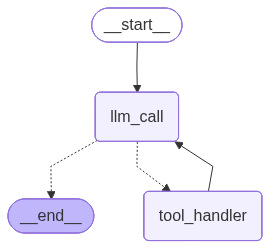

In [42]:
agent

다음과 같이 동작하는 그래프가 생성됩니다.

1. LLM 결정으로 시작
2. 도구 실행 또는 종료로 조건부 라우팅
3. 도구 실행 후, 다음 결정을 위해 LLM으로 복귀
4. 완료되거나 도구가 호출되지 않을 때까지 반복

### 라우터와 에이전트를 결합한 워크플로

라우터와 에이전트를 결합할 수 있습니다.

In [43]:
app_with_router = (
    StateGraph(State)
    .add_node(triage_router)
    .add_node("response_agent", agent)
    .set_entry_point("triage_router")
).compile()

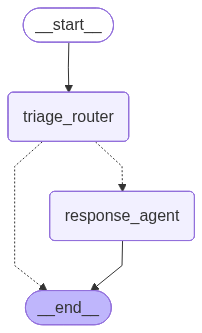

In [44]:
app_with_router

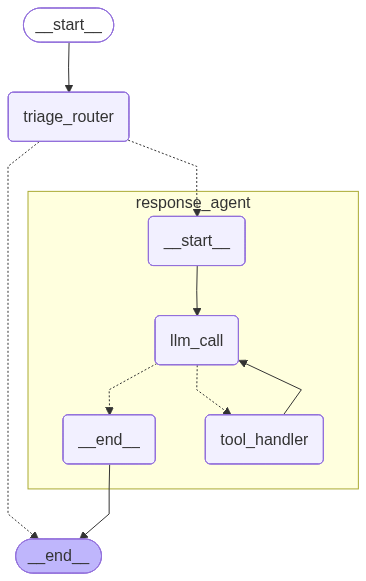

In [45]:
from IPython.display import Image


display(Image(app_with_router.get_graph(xray=True).draw_mermaid_png()))

이것은 higher-level composition으로, 다음과 같은 단계로 실행됩니다.

1. 먼저 분류 라우터가 이메일을 분석합니다
2. 필요한 경우 응답 에이전트가 응답 작성 작업을 처리합니다
3. 분류에서 응답이 필요 없다고 판단하거나 응답 에이전트가 작업을 완료하면 워크플로가 종료됩니다

In [ ]:
email_input = {
    "author": "시스템 관리자 <sysadmin@company.com>",
    "to": "개발팀 <dev@company.com>",
    "subject": "예정된 유지보수 - 데이터베이스 가동 중단",
    "email_thread": "개발팀 여러분,\n\n오늘 밤 미국 동부 표준시 기준 오전 2시부터 4시까지 프로덕션 데이터베이스에 대한 정기 점검을 실시할 예정임을 알려드립니다. 이 시간 동안 모든 데이터베이스 서비스가 이용 불가합니다.\n\n해당 시간대에 중요한 배포 작업이 계획되지 않도록 업무 일정을 조정해 주시기 바랍니다.\n\n감사합니다,\n시스템 관리팀",
}

response = app_with_router.invoke({"email_input": email_input})
for msg in response["messages"]:
    msg.pretty_print()

🔔 분류: 알림 - 이 이메일에는 중요한 정보가 포함되어 있습니다


In [49]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph


email_input = {
    "author": "앨리스 스미스 <alice.smith@company.com>",
    "to": "존 도이 <john.doe@company.com>",
    "subject": "API 문서에 관한 간단한 질문입니다",
    "email_thread": "존 씨, 안녕하세요.\n새 인증 서비스의 API 문서를 검토하던 중 몇 가지 엔드포인트가 사양에서 누락된 것 같습니다. 이것이 의도된 것인지, 아니면 문서를 업데이트해야 하는지 확인해 주실 수 있나요?\n구체적으로 살펴본 엔드포인트는 다음과 같습니다:\n- /auth/refresh\n- /auth/validate\n감사합니다!\n앨리스",
}

config = RunnableConfig(configurable={"thread_id": "1"})

invoke_graph(
    graph=app_with_router,
    inputs={"email_input": email_input},
    config=config
)

📧 분류: 응답 필요 - 이 이메일은 답변이 필요합니다

🔄 Node: triage_router 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
('user', '이메일에 답장하세요: \n\n\n\n**Subject**: API 문서에 관한 간단한 질문입니다\n**From**: 앨리스 스미스 <alice.smith@company.com>\n**To**: 존 도이 <john.doe@company.com>\n\n존 씨, 안녕하세요.\n새 인증 서비스의 API 문서를 검토하던 중 몇 가지 엔드포인트가 사양에서 누락된 것 같습니다. 이것이 의도된 것인지, 아니면 문서를 업데이트해야 하는지 확인해 주실 수 있나요?\n구체적으로 살펴본 엔드포인트는 다음과 같습니다:\n- /auth/refresh\n- /auth/validate\n감사합니다!\n앨리스\n\n---\n')
classification_decision:
respond

🔄 Node: llm_call in [response_agent] 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================== Ai Message ==================================
Tool Calls:
  write_email (call_6mBGrffs6tfl4zaQvZ5V6vsr)
 Call ID: call_6mBGrffs6tfl4zaQvZ5V6vsr
  Args:
    to: alice.smith@company.com
    subject: Re: API 문서에 관한 간단한 질문입니다
    content: 앨리스 님, 안녕하세요.

새 인증 서비스의 API 문서 관련하여 문의 주신 /auth/refresh 및 /auth/validate 엔드포인트 누락 여부에 대해 확인 중입니다. 문서가 의도된 대로 작성된 것인지, 아니면 업데이트가 필요한지 내부적으로 검토 후 빠르게 답

ValidationError: 3 validation errors for write_email
to
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
subject
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
content
  Field required [type=missing, input_value={}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing

## 로컬 배포를 통한 테스트

LangGraph Studio에서 로컬 테스트를 실행하려면 다음 명령어를 사용하세요:

```shell
cd studio
langgraph dev
```